### NLP From Scratch: Classifying Names with a Character-Level RNN

**************************************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`

#### Print your name

In [1]:
## Your code here 
print("Exercise by: Janne Bragge")

Exercise by: Janne Bragge


We will be building and training a basic character-level RNN to classify
words. This tutorial, along with the following two, show how to do
preprocess data for NLP modeling "from scratch", in particular not using
many of the convenience functions of `torchtext`, so you can see how
preprocessing for NLP modeling works at a low level.

A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <https://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <https://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [2]:
%matplotlib inline

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('../data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('../data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['../data/names/Portuguese.txt', '../data/names/English.txt', '../data/names/Vietnamese.txt', '../data/names/Finnish.txt', '../data/names/French.txt', '../data/names/Chinese.txt', '../data/names/German.txt', '../data/names/Polish.txt', '../data/names/Czech.txt', '../data/names/Arabic.txt', '../data/names/Dutch.txt', '../data/names/Russian.txt', '../data/names/Scottish.txt', '../data/names/Japanese.txt', '../data/names/Greek.txt', '../data/names/Korean.txt', '../data/names/Spanish.txt', '../data/names/Irish.txt', '../data/names/Italian.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [4]:
finnish_names = (category_lines['Finnish'])
print(category_lines['Finnish'][:5])

['Aadan', 'Aakala', 'Aakko', 'Aakkula', 'Aakula']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [5]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <https://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [6]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [7]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [8]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9764, -2.9447, -3.0111, -2.8984, -3.0050, -2.9151, -2.9790, -2.8480,
         -2.9217, -2.9920, -2.9788, -2.8311, -2.8750, -2.9755, -3.0420, -2.9342,
         -2.9236, -2.9774, -2.9438]], grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [9]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Russian', 11)


We will also want a quick way to get a training example (a name and its
language):




In [10]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = French / line = Travers
category = Japanese / line = Shirahata
category = Dutch / line = Slootmaekers
category = Russian / line = Valyushkis
category = Korean / line = San
category = Finnish / line = Bhandari
category = Polish / line = Gniewek
category = French / line = Severin
category = Chinese / line = Ming
category = Chinese / line = Chin


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [11]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [12]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [13]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

# Keep track of correct predictions
correct_count = 0

# Keep track of cumulative loss and iterations
total_loss = 0
total_iters = 0

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    total_loss += loss #update total loss
    total_iters += 1 #update total iters

    guess, guess_i = categoryFromOutput(output)
    if guess == category:
        correct_count += 1

    # Print iter number, cumulative average loss, name and guess
    if iter % print_every == 0:
        accuracy = correct_count / print_every  # Calculate accuracy
        cumulative_average_loss = total_loss / total_iters # Calculate cumulative average loss
        print('%d %d%% (%s) Loss: %.4f Accuracy: %.4f' % (iter, iter / n_iters * 100, timeSince(start), cumulative_average_loss, accuracy))
        correct_count = 0  # Reset correct count for the next interval
    # --- MODIFIED SECTION END ---

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 44s) Loss: 2.7961 Accuracy: 0.1900
10000 10% (1m 27s) Loss: 2.5978 Accuracy: 0.2760
15000 15% (2m 11s) Loss: 2.4505 Accuracy: 0.3404
20000 20% (2m 55s) Loss: 2.3347 Accuracy: 0.3834
25000 25% (3m 39s) Loss: 2.2545 Accuracy: 0.3954
30000 30% (4m 22s) Loss: 2.1844 Accuracy: 0.4396
35000 35% (5m 6s) Loss: 2.1201 Accuracy: 0.4630
40000 40% (5m 49s) Loss: 2.0647 Accuracy: 0.4810
45000 45% (6m 33s) Loss: 2.0137 Accuracy: 0.4998
50000 50% (7m 16s) Loss: 1.9710 Accuracy: 0.5110
55000 55% (8m 0s) Loss: 1.9327 Accuracy: 0.5184
60000 60% (8m 43s) Loss: 1.8998 Accuracy: 0.5306
65000 65% (9m 26s) Loss: 1.8706 Accuracy: 0.5348
70000 70% (10m 11s) Loss: 1.8435 Accuracy: 0.5464
75000 75% (10m 55s) Loss: 1.8191 Accuracy: 0.5464
80000 80% (11m 39s) Loss: 1.7943 Accuracy: 0.5584
85000 85% (12m 23s) Loss: 1.7727 Accuracy: 0.5576
90000 90% (13m 6s) Loss: 1.7525 Accuracy: 0.5648
95000 95% (13m 50s) Loss: 1.7334 Accuracy: 0.5674
100000 100% (14m 33s) Loss: 1.7155 Accuracy: 0.5692


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




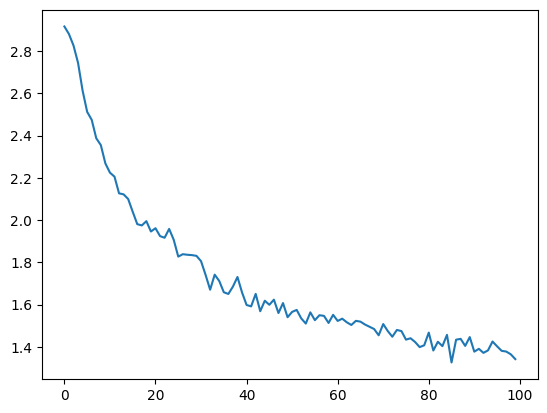

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




/tmp/ipykernel_1718239/3585656379.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_1718239/3585656379.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


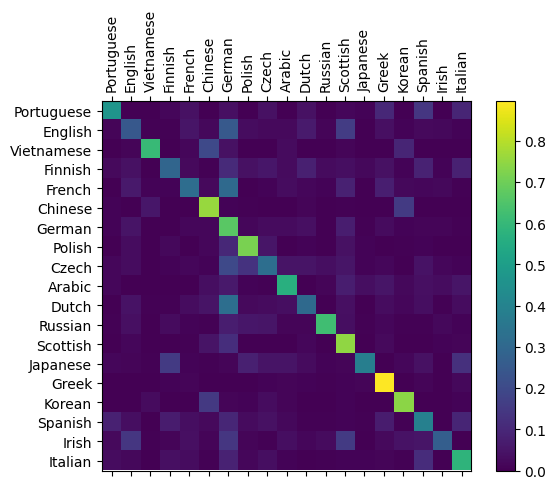

In [15]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [16]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.67) Czech
(-1.64) Polish
(-1.65) Russian

> Jackson
(-0.22) Scottish
(-2.19) English
(-3.04) Dutch

> Satoshi
(-1.44) Italian
(-1.69) Polish
(-1.83) Finnish


In [17]:
# Task 3

n_iters = 100000
print_every = 5000
#plot_every = 1000
n_hidden = 128

# --- Määrittele categories lista ---
categories = all_categories

# Keep track of losses for plotting
current_loss = 0
all_losses = []

# Keep track of correct predictions
correct_count = 0

# Keep track of cumulative loss and iterations
total_loss = 0
total_iters = 0

# --- VERKON UUDELLEENALUSTUS ---
rnn = RNN(n_letters, n_hidden, len(categories)) # Käytetään len(categories) n_categories arvoon

# --- KOULUTUS 100 000 ITERAATIOLLA ---
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    total_loss += loss
    total_iters += 1

    guess, guess_i = categoryFromOutput(output)
    #correct = '✓' if guess == category else '✗ (%s)' % category
    if guess == category:
        correct_count += 1

    if iter % print_every == 0:
        accuracy = correct_count / print_every
        cumulative_average_loss = total_loss / total_iters
        print('%d %d%% (%s) Cumulative Average Loss: %.4f Accuracy: %.4f' % (iter, iter / n_iters * 100, timeSince(start), cumulative_average_loss, accuracy))
        correct_count = 0

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

# --- SUOMALAISTEN NIMIEN TARKKUUDEN LASKEMINEN ---
correct_finnish = 0
total_finnish = len(finnish_names)

with torch.no_grad():
    for name in finnish_names:
        line_tensor = lineToTensor(name)
        category_tensor = torch.tensor([categories.index('Finnish')], dtype=torch.long)
        # Alusta hidden state
        hidden = rnn.initHidden()
        # Käy läpi line_tensor kirjain kirjaimelta
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        guess, guess_i = categoryFromOutput(output)
        if guess == 'Finnish':
            correct_finnish += 1

accuracy = correct_finnish / total_finnish * 100
print(f'Tarkkuus suomalaisilla nimillä: {accuracy:.2f}%')

# Muokattu train funktio
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

5000 5% (0m 43s) Cumulative Average Loss: 2.8087 Accuracy: 0.1782
10000 10% (1m 25s) Cumulative Average Loss: 2.6100 Accuracy: 0.2746
15000 15% (2m 9s) Cumulative Average Loss: 2.4693 Accuracy: 0.3434
20000 20% (2m 53s) Cumulative Average Loss: 2.3611 Accuracy: 0.3760
25000 25% (3m 36s) Cumulative Average Loss: 2.2705 Accuracy: 0.4140
30000 30% (4m 19s) Cumulative Average Loss: 2.1944 Accuracy: 0.4382
35000 35% (5m 3s) Cumulative Average Loss: 2.1261 Accuracy: 0.4764
40000 40% (5m 47s) Cumulative Average Loss: 2.0722 Accuracy: 0.4810
45000 45% (6m 31s) Cumulative Average Loss: 2.0250 Accuracy: 0.4960
50000 50% (7m 14s) Cumulative Average Loss: 1.9844 Accuracy: 0.4972
55000 55% (7m 57s) Cumulative Average Loss: 1.9480 Accuracy: 0.5002
60000 60% (8m 41s) Cumulative Average Loss: 1.9113 Accuracy: 0.5340
65000 65% (9m 24s) Cumulative Average Loss: 1.8784 Accuracy: 0.5372
70000 70% (10m 8s) Cumulative Average Loss: 1.8514 Accuracy: 0.5436
75000 75% (10m 51s) Cumulative Average Loss: 1.8273 

In [18]:
predict('Bragge')


> Bragge
(-1.11) French
(-1.55) Italian
(-1.80) English


# Reflection

1. How accurate neural network is?
2. How many % of Finnish names network predicts correctly as Finnish? 
3. Try your sur name. What neural netwoprk predicts?
4. What you could do to improve neural network performance? 

*Your answers here...*

## Great job!